In [15]:
%load_ext autoreload

%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
import problem
import jax.numpy as jnp
import jax.scipy as jsp
import jax
import matplotlib.pyplot as plt
import yaml



#from problem import *

In [150]:
with open('config_basic.yml', 'r') as file:
        c = yaml.safe_load(file)

# Create spatial discretisation 
lat_first = c['spatial_discretisation']['lat_first']
lat_final = c['spatial_discretisation']['lat_final']
lat_n     = c['spatial_discretisation']['lat_n']
lng_first = c['spatial_discretisation']['lng_first']
lng_final = c['spatial_discretisation']['lng_final']
lng_n     = c['spatial_discretisation']['lng_n']

lat,lng = jnp.mgrid[lat_first:lat_final:lat_n*1j,
                    lng_first:lng_final:lng_n*1j]

# Test boundary aware functional equations

In [164]:
DTHETA, DLAMBDA = 1,1

class BoundaryAware():

    def __init__(self, state, neighbours):
        self.state = state
        self.nbs = neighbours

    def laplacian(self, y):

        yb = y*self.state

        y_i_next = jnp.roll(yb, shift=1, axis=-2)
        y_i_prev = jnp.roll(yb, shift=-1,axis=-2)
        y_j_next = jnp.roll(yb, shift=1 ,axis=-1)
        y_j_prev = jnp.roll(yb, shift=-1,axis=-1)
        return y*(1-self.state) + self.state*(y_j_next #
                                            + y_i_next
                                            - self.nbs * yb 
                                            + y_j_prev 
                                            + y_i_prev) / (DTHETA*DLAMBDA)

    def ptheta(self, y):
        y_i_next = jnp.roll(y, shift=1, axis=-2)
        y_i_prev = jnp.roll(y, shift=-1,axis=-2)

        f_i_next = jnp.roll(self.state, shift=1, axis=-2)
        f_i_prev = jnp.roll(self.state, shift=-1,axis=-2)

        return self.state * ( 
                 f_i_next * f_i_prev     * (y_i_next - y_i_prev) / 2
               #+ f_i_next * (1-f_i_prev) * (y_i_next - y) 
              # + (1-f_i_next) * f_i_prev * (y - y_i_prev) 
            )/DTHETA
             
    def plambda(self, y):
        y_j_next = jnp.roll(y, shift=1, axis=-1)
        y_j_prev = jnp.roll(y, shift=-1,axis=-1)

        f_j_next = jnp.roll(self.state, shift=1, axis=-1)
        f_j_prev = jnp.roll(self.state, shift=-1,axis=-1)

        return self.state * ( 
                 f_j_next * f_j_prev     * (y_j_next - y_j_prev) / 2
              # + f_j_next * (1-f_j_prev) * (y_j_next - y) 
              # + (1-f_j_next) * f_j_prev * (y - y_j_prev) 
            )/DTHETA

    def gradient(self, y):
        return jnp.array( (self.ptheta(y), self.plambda(y)))
    
    def divergence(self, y):
        y_i_next = jnp.roll(y[0], shift=1, axis=-2)
        y_i_prev = jnp.roll(y[0], shift=-1,axis=-2)
        y_j_next = jnp.roll(y[1], shift=1 ,axis=-1)
        y_j_prev = jnp.roll(y[1], shift=-1,axis=-1)
        return self.state*(y_i_next - y_i_prev + y_j_next - y_j_prev)

In [183]:
def neighbours(state):
    s_i_next = jnp.roll(state, shift=1, axis=-2)
    s_i_prev = jnp.roll(state, shift=-1,axis=-2)
    s_j_next = jnp.roll(state, shift=1 ,axis=-1)
    s_j_prev = jnp.roll(state, shift=-1,axis=-1)

    return s_i_next + s_i_prev + s_j_next + s_j_prev

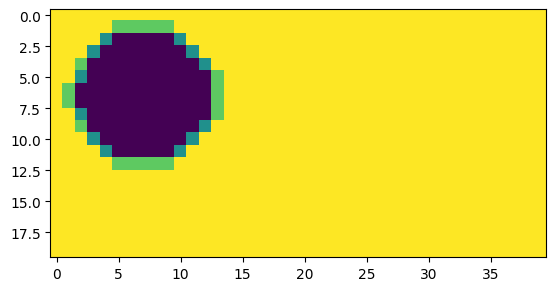

In [186]:
v = jnp.zeros((2, lat.shape[0], lat.shape[1]))
v = v.at[1].set( -1 * ((jnp.square(lat+0.5) + jnp.square(lng+0.5))<1) )

state = 1 - 1 * ((jnp.square(lat+0.5) + jnp.square(lng+2))<0.7)
state_neighbours = neighbours(state)*state

plt.imshow(state_neighbours*state)
ba = BoundaryAware(state, state_neighbours)

Text(0.5, 1.0, 'purple solid, yellow fluid')

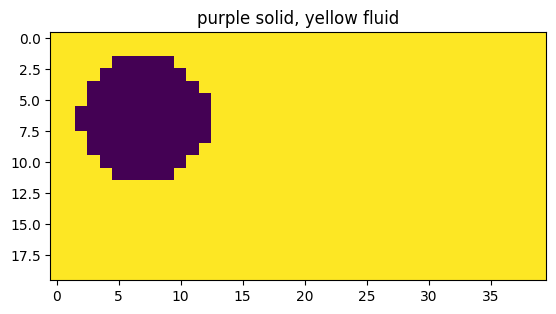

In [187]:
plt.imshow(state)
plt.title('purple solid, yellow fluid')

Text(0.5, 1.0, ' horizontal derivative of horizontal velocity')

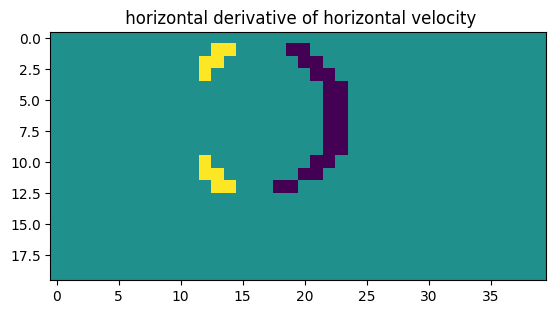

In [188]:
plt.imshow(ba.plambda(v[1]))
plt.title(' horizontal derivative of horizontal velocity')

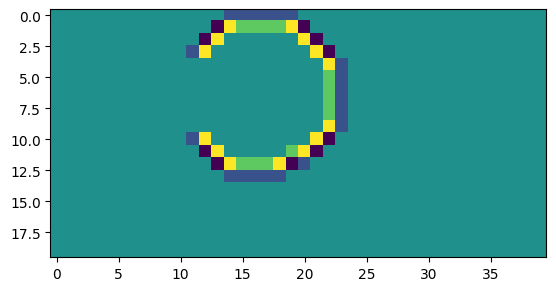

In [189]:
plt.imshow(ba.laplacian(v[1])*state)

(20, 40)


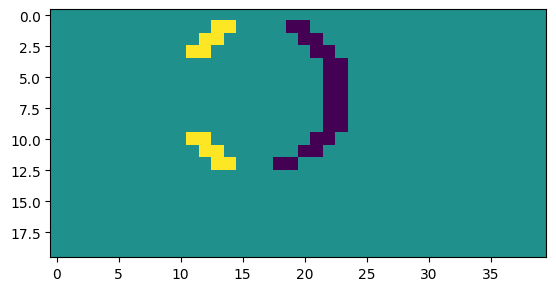

In [190]:
res = ba.divergence(v)
print(res.shape)

plt.imshow(ba.divergence(v))

# test divfree projection with boundary condidtions

In [224]:
#from problem import *



def project_divergencefree2(v, q_guess=None, state=None, fluid_neighbours=None, cg_runs = 2):

    ba = BoundaryAware(state, fluid_neighbours)

    q, _ = jsp.sparse.linalg.cg(
            ba.laplacian,
            -ba.divergence(v), 
            x0=q_guess)

    v_f = (v + ba.gradient(q))
    # Repeats as conjugate gradient descent does not necessarily converge to correct solution after 1 run
    for i in range(cg_runs):
        # q is the exact "pressure" needed to maintain densities
        qi, _ = jsp.sparse.linalg.cg(
            ba.laplacian,
            -ba.divergence(v_f), 
            maxiter= 1000)
        #q_total += q
        v_f += ba.gradient(qi)

    return v_f, q
    #return  q
    #return v + gradient(q)


In [213]:
# Initial conditions

v = jnp.zeros((2, lat.shape[0], lat.shape[1]))
v = v.at[1].set( -1 * ((jnp.square(lat+0.5) + jnp.square(lng+0.5))<1) )


state = 1 - 1 * ((jnp.square(lat+0.5) + jnp.square(lng+2))<0.7)
v*=state

fluid_neighbours = neighbours(state)

ba = BoundaryAware(state, fluid_neighbours)


Text(0.5, 1.0, 'blurred horizontal v')

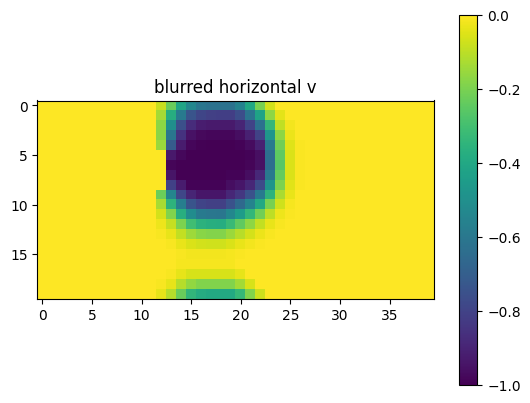

In [209]:
def blur(arr):
    return (jnp.roll(arr,  1, axis=-2)
          + jnp.roll(arr, -1, axis=-2)
          + jnp.roll(arr,  1, axis=-1)
          + jnp.roll(arr, -1, axis=-2)
          + arr) / (fluid_neighbours + 1 + 1-state) *state

v = blur(v)
#v = v.at[:,state==0].set(0)
plt.imshow(v[1])
plt.colorbar()
plt.title('blurred horizontal v')

Text(0.5, 1.0, 'divergence of v')

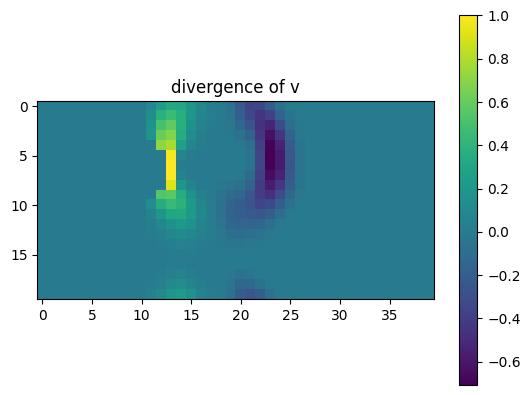

In [210]:
plt.imshow(ba.divergence(v))
plt.colorbar()
plt.title('divergence of v')

-2304.5 3910.5625


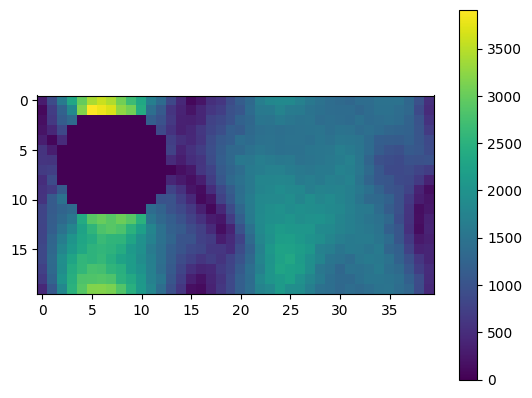

In [227]:
def normv(v): return jnp.sqrt(jnp.square(v[0]) + jnp.square(v[1]))

v_f, q1 = project_divergencefree2(v, state=state, fluid_neighbours = fluid_neighbours, cg_runs = 10)

print(jnp.amin(v_f), jnp.amax(v_f))

plt.imshow((normv(v_f)))
plt.colorbar()

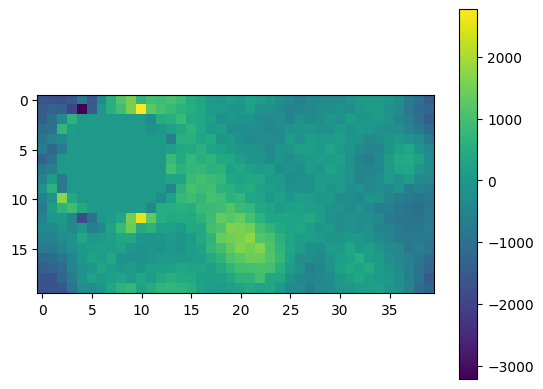

In [228]:
plt.imshow(ba.divergence(v_f))
plt.colorbar()

# bathymetry

In [28]:
import numpy as np

In [29]:
# Assuming `data` is your N-dimensional numpy array
data = np.random.rand(10, 20, 30)  # Example: 3D array
print('data created')

def plot_slice(x=0):
    plt.imshow(data[:, :, x], interpolation='nearest')
    plt.show()

interact(plot_slice, x=IntSlider(min=0, max=data.shape[2]-1, step=1, value=0))

data created


NameError: name 'interact' is not defined

opening path  /mnt/c/Users/spenc/OneDrive/Documents/GitHub/THCsim/resources/map/gebco_08_rev_bath_3600x1800_color.jpg
/mnt/c/Users/spenc/OneDrive/Documents/GitHub/THCsim/resources/map/gebco_08_rev_bath_3600x1800_color.jpg
(1800, 3600, 3)


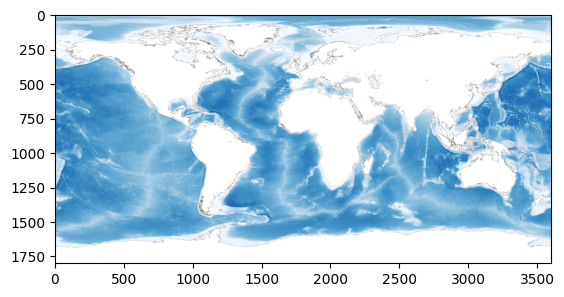

In [ ]:
import cv2
import numpy as np
import os

def get_map_path(config):

    if config["map"]["mask_image_path_relative"]:
        print('opening path ', os.path.join( os.getcwd(), config["map"]["mask_image_path"] ))
        print(os.path.join( os.getcwd(), config["map"]["mask_image_path"] ))
        return os.path.join( os.getcwd(), config["map"]["mask_image_path"] )
    else:
        return config["map"]["mask_image_path"]


def load_np(config):

    image_np = cv2.imread(get_map_path(config)) 

    return image_np[:,:,::-1]



import matplotlib.pyplot as plt

config = {"map": {"mask_image_path_relative": True, 
                    "mask_image_path": "resources/map/gebco_08_rev_bath_3600x1800_color.jpg"}}

im = load_np(config).astype(int)
print(im.shape)

im[:,:,:] += (np.isclose(im[:,:,0],im[:,:,2], atol=4))[:,:,np.newaxis]*255

im[im>255]=255

plt.imshow(im)
#plt.show()